In [1]:
# Bước 1: Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

import graphviz  

####################################
# Bước 2: Đọc và chuẩn bị dữ liệu
####################################

# Đọc dữ liệu Mushroom từ file CSV đã tải về
agaricus_lepiota_data = pd.read_csv('agaricus-lepiota.data') #Chèn đường dẫn thực tế

# Đặt tên cho các cột dựa trên mô tả trong agaricus-lepiota.names
columns = [
    'poisonous', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing',
    'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
    'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 
    'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Hiển thị lại dữ liệu với tên cột
agaricus_lepiota_data.columns = columns

# Lặp qua tất cả các cột để áp dụng encode giá trị các cột
le = LabelEncoder()
for col in agaricus_lepiota_data.columns:
    agaricus_lepiota_data[col] = le.fit_transform(agaricus_lepiota_data[col])

# Kiểm tra dữ liệu
print(agaricus_lepiota_data.head())
print(agaricus_lepiota_data.info())

# Giả sử cột 'label' là nhãn, phần còn lại là features
features_m = agaricus_lepiota_data.drop('poisonous', axis=1)
labels_m = agaricus_lepiota_data['poisonous']

# Tạo hàm tiện ích để chia dữ liệu theo nhiều tỉ lệ khác nhau và lưu lại
def stratified_split(X, y, train_size, random_state=42):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

train_test_ratios = [0.4, 0.6, 0.8, 0.9]

splits_m = {}  
for ratio in train_test_ratios:
    X_train, X_test, y_train, y_test = stratified_split(features_m, labels_m, train_size=ratio)
    splits_m[ratio] = (X_train, X_test, y_train, y_test)



   poisonous  cap-shape  cap-surface  cap-color  bruises  odor  \
0          0          5            2          9        1     0   
1          0          0            2          8        1     3   
2          1          5            3          8        1     6   
3          0          5            2          3        0     5   
4          0          5            3          9        1     0   

   gill-attachment  gill-spacing  gill-size  gill-color  ...  \
0                1             0          0           4  ...   
1                1             0          0           5  ...   
2                1             0          1           5  ...   
3                1             1          0           4  ...   
4                1             0          0           5  ...   

   stalk-surface-below-ring  stalk-color-above-ring  stalk-color-below-ring  \
0                         2                       7                       7   
1                         2                       7         

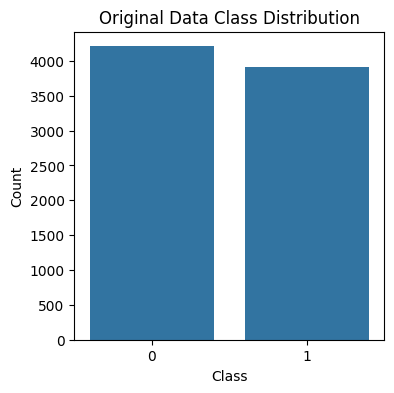

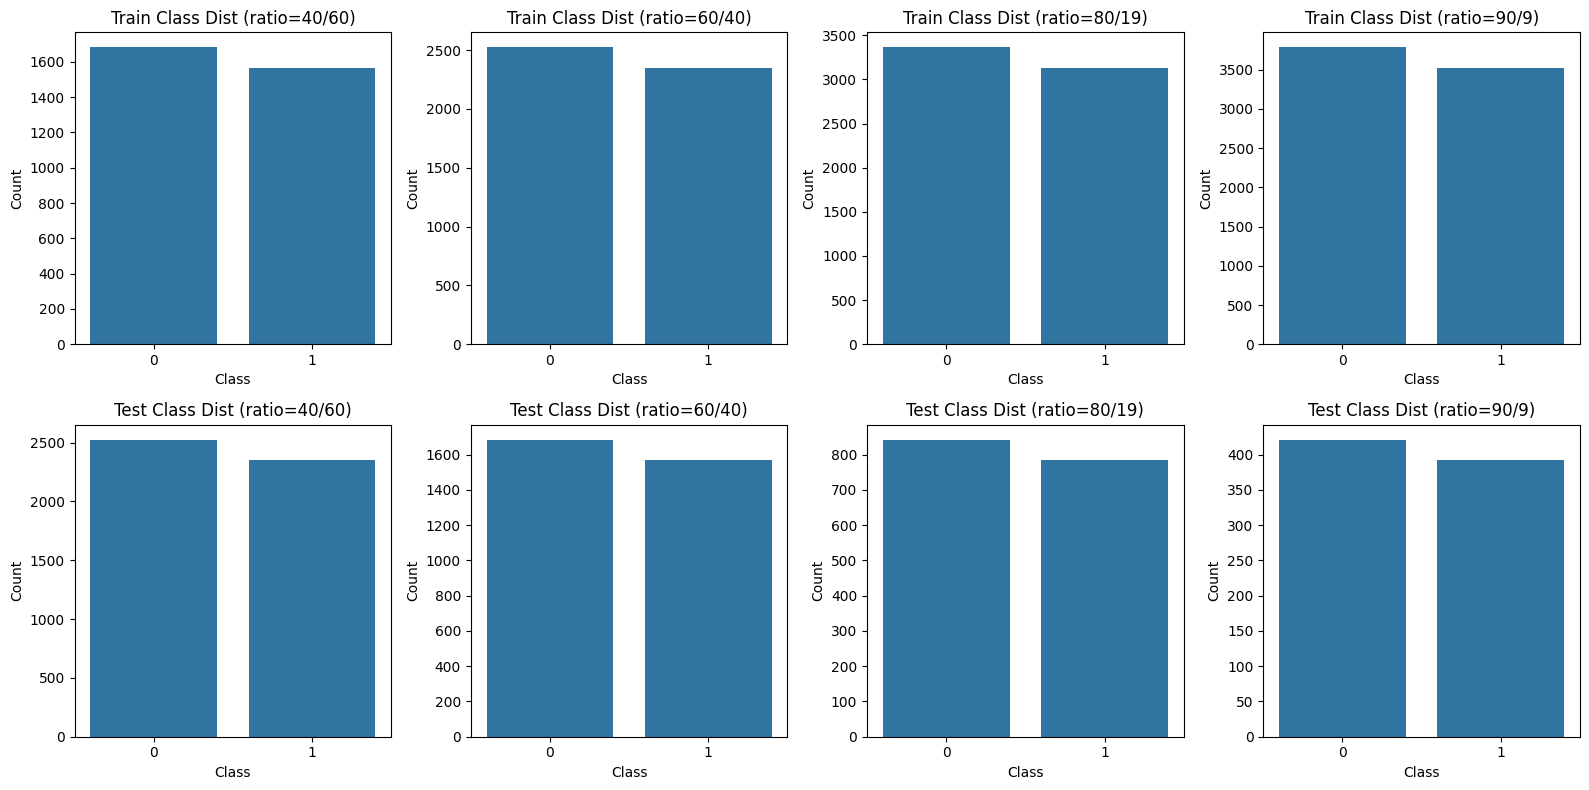

In [2]:

####################################
# Bước 3: Trực quan hóa phân bố lớp
####################################

def plot_class_distribution(y, ax, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)
    sns.barplot(x=unique, y=counts, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

# Vẽ phân bố lớp cho bộ dữ liệu gốc
fig, ax = plt.subplots(figsize=(4, 4))
plot_class_distribution(labels_m, ax, title="Original Data Class Distribution")

# Vẽ phân bố cho từng tập
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Vẽ phân bố lớp cho từng tập train
for i, ratio in enumerate(train_test_ratios):
    X_train, X_test, y_train, y_test = splits_m[ratio]
    plot_class_distribution(y_train, title=f"Train Class Dist (ratio={int(ratio*100)}/{int((1-ratio)*100)})", ax=axes[0, i])

# Vẽ phân bố lớp cho từng tập test
for i, ratio in enumerate(train_test_ratios):
    X_train, X_test, y_train, y_test = splits_m[ratio]
    plot_class_distribution(y_test, title=f"Test Class Dist (ratio={int(ratio*100)}/{int((1-ratio)*100)})", ax=axes[1, i])

plt.tight_layout()
plt.show()

*  decision_tree_m_40_60.png


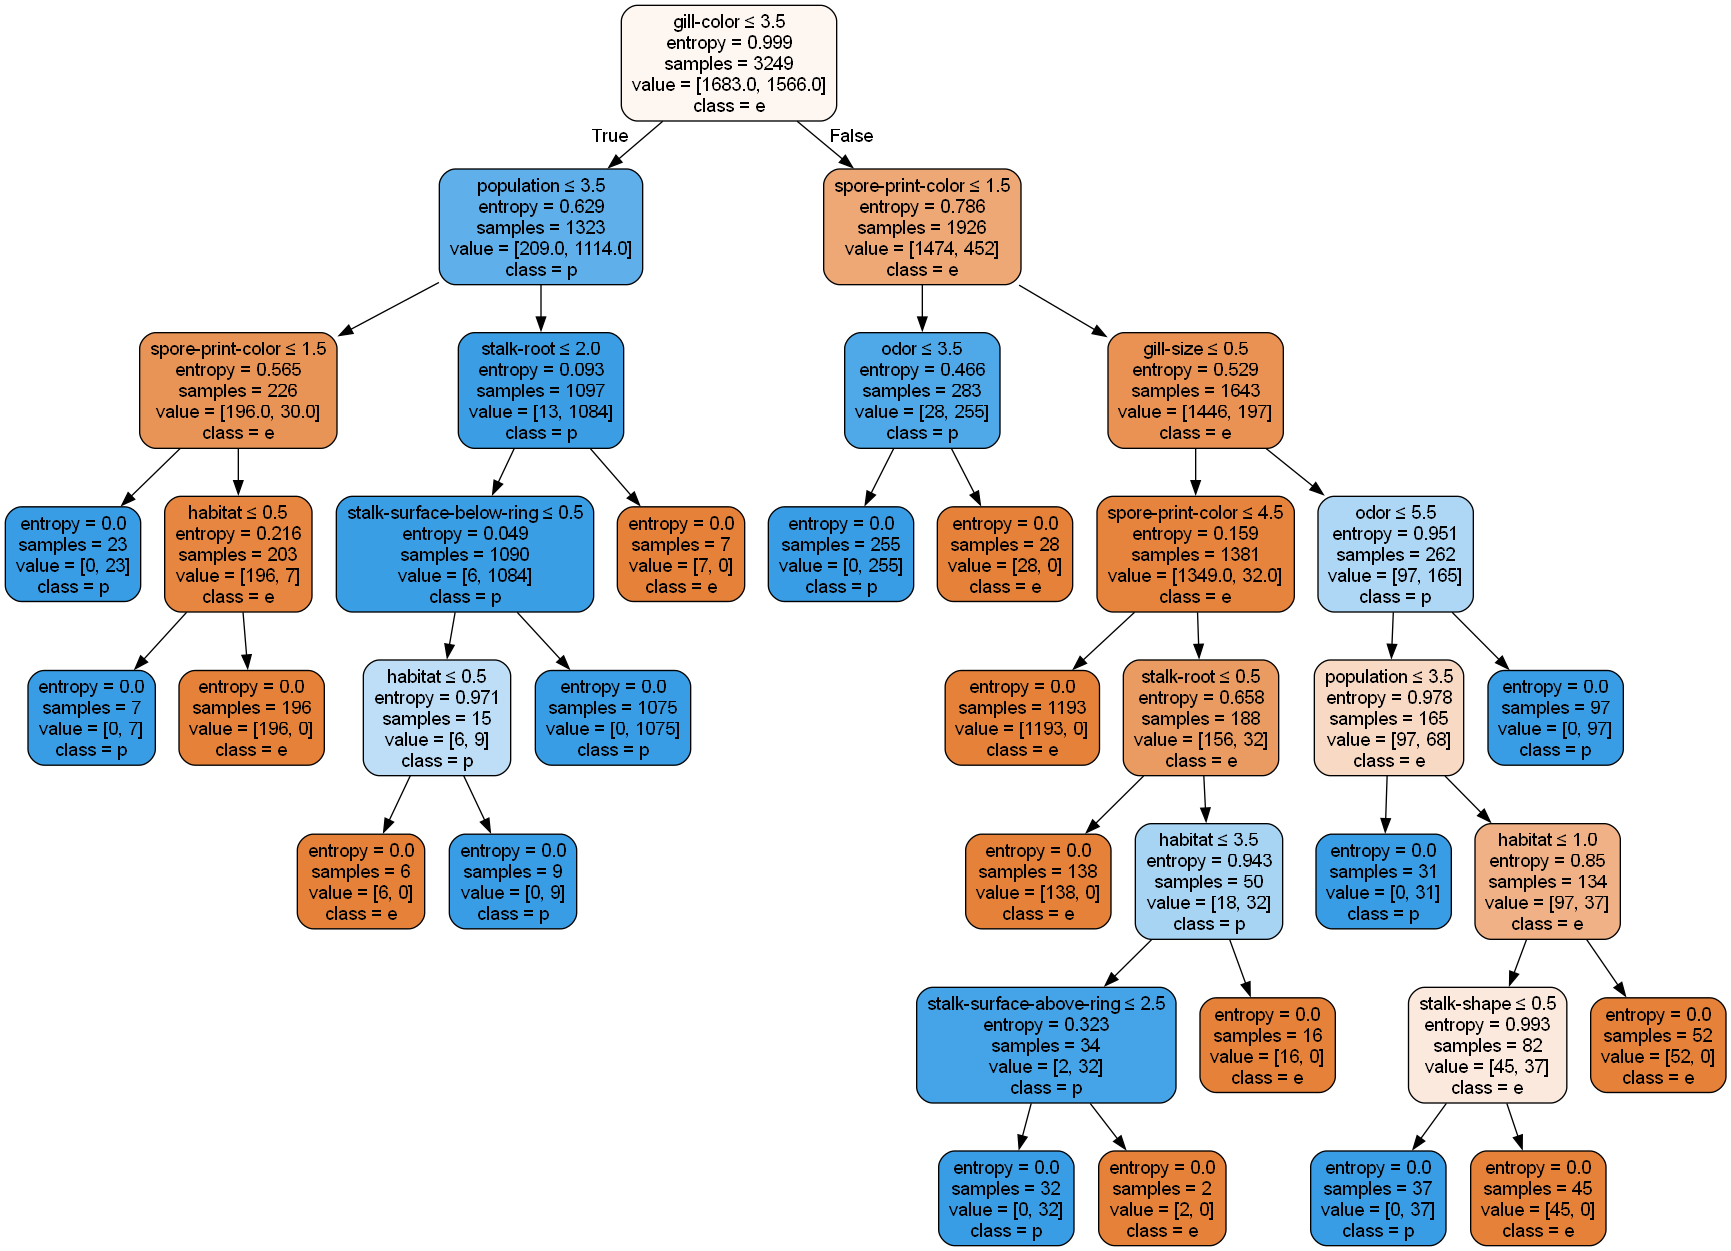

*  decision_tree_m_60_40.png


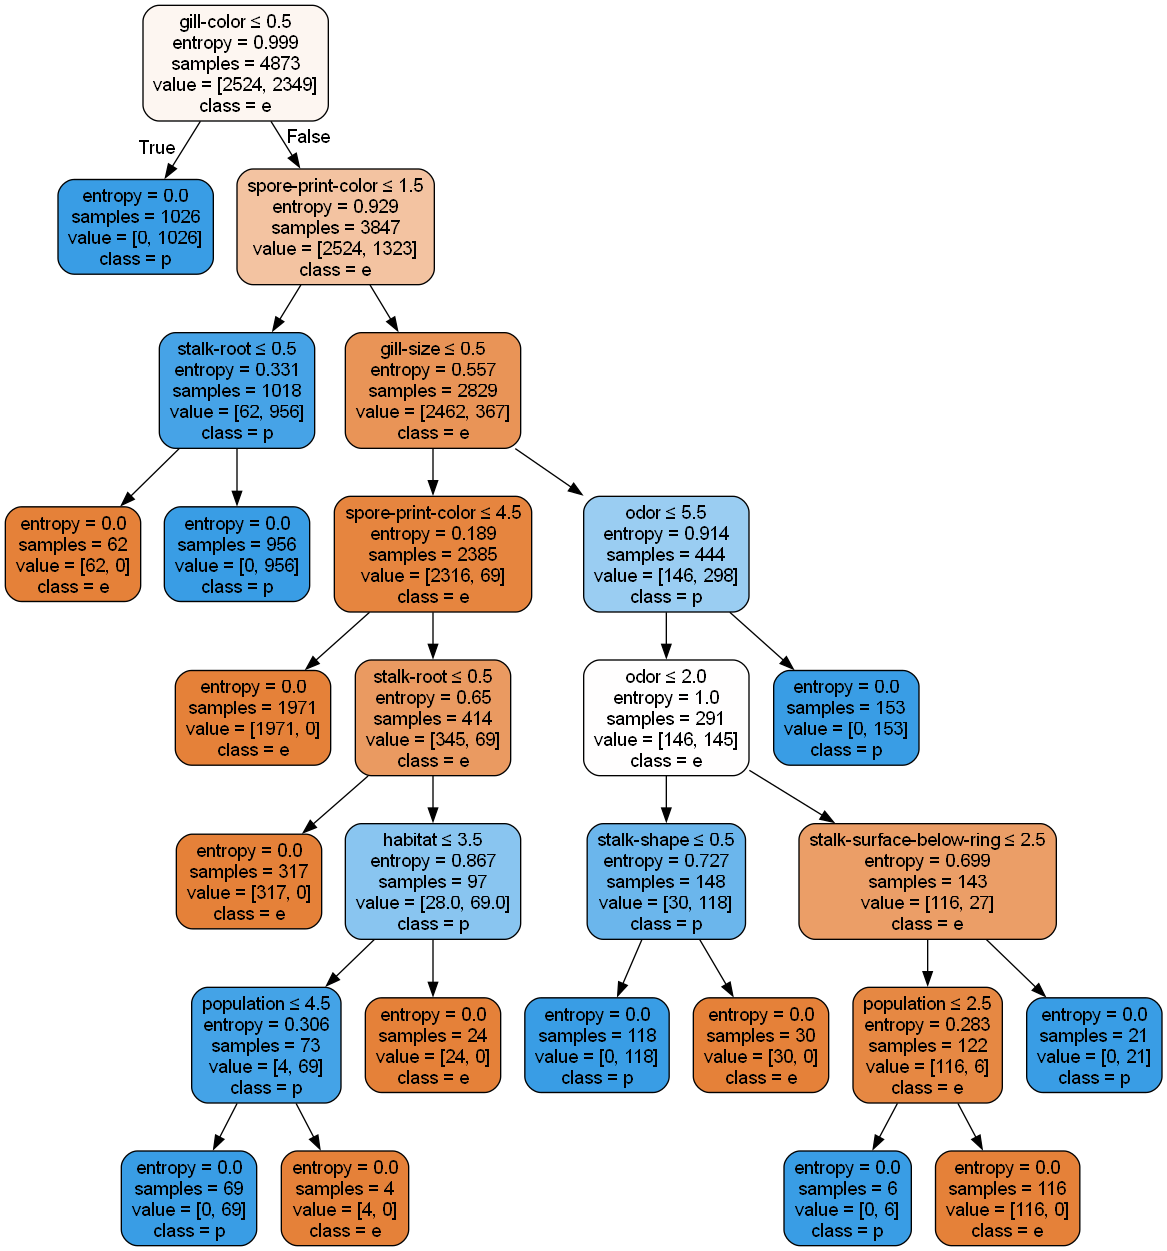

*  decision_tree_m_80_19.png


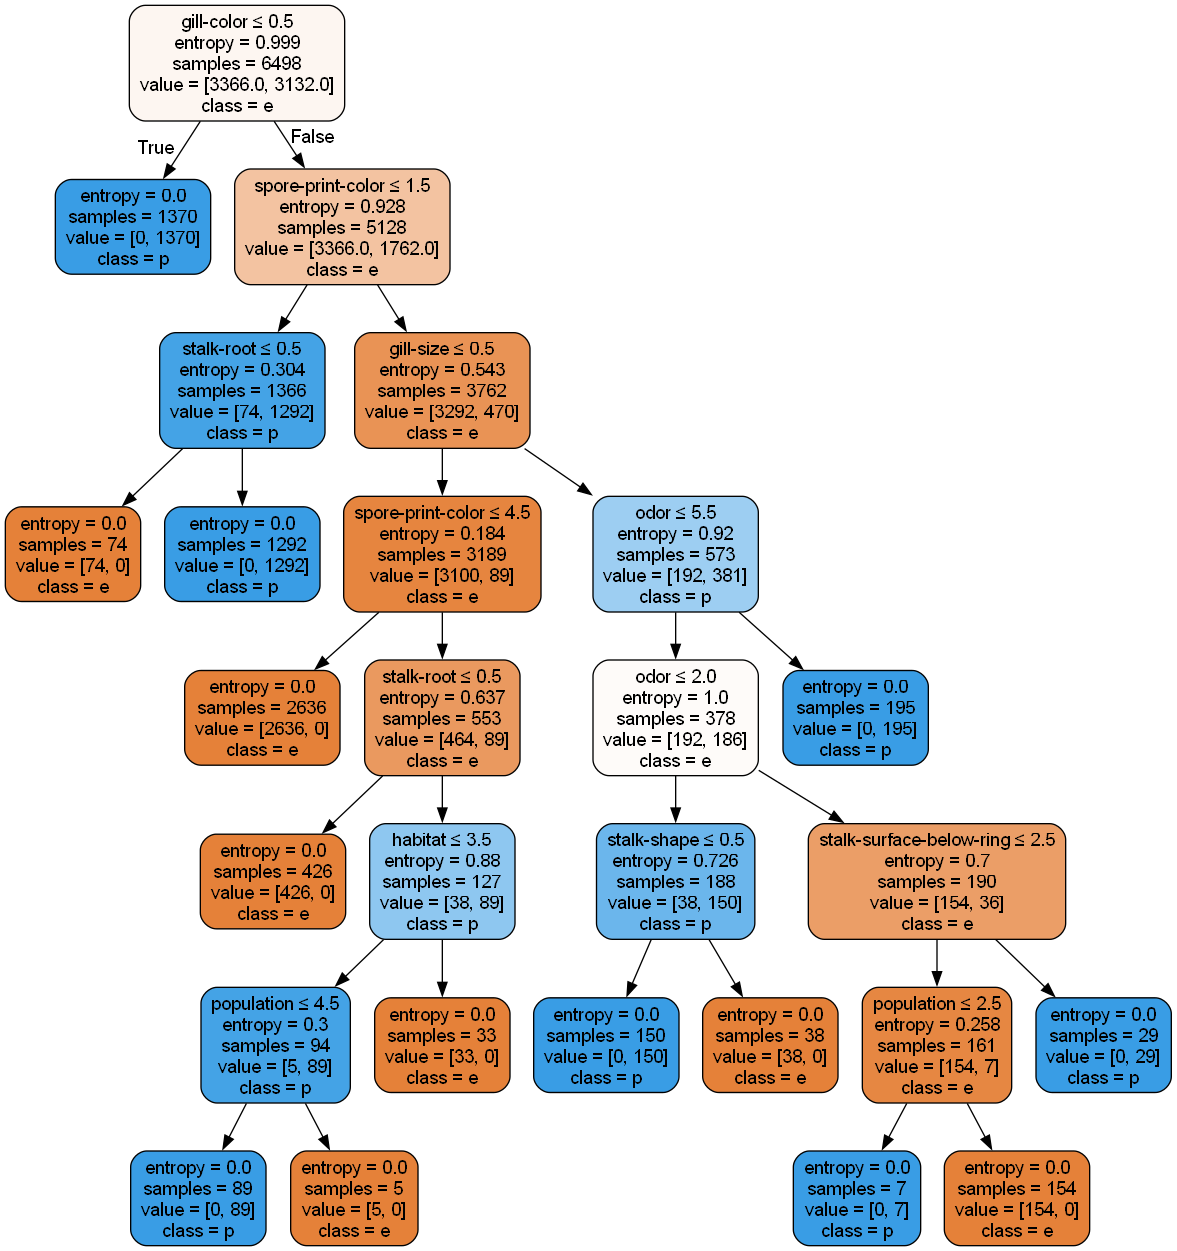

*  decision_tree_m_90_9.png


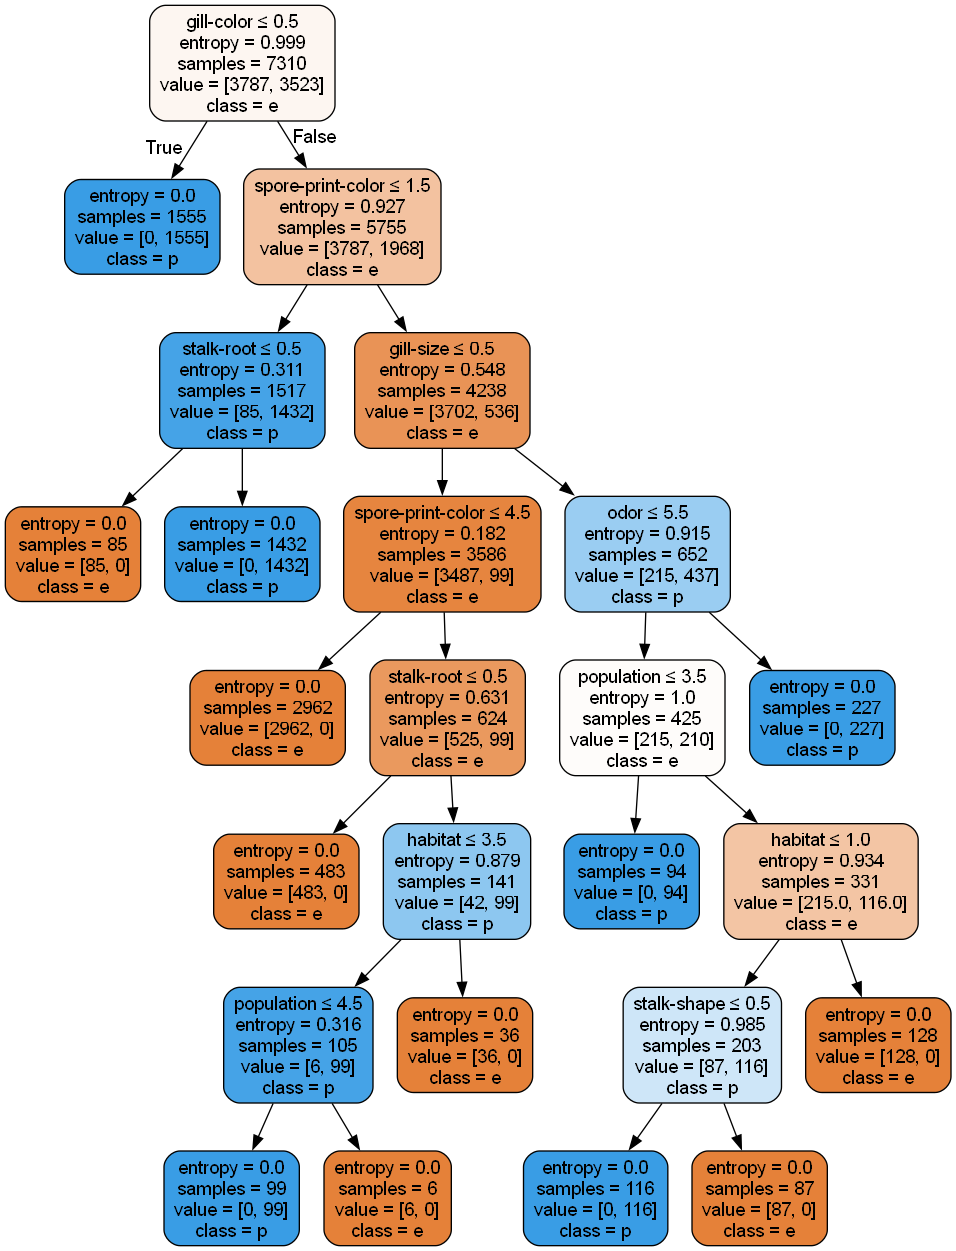

In [3]:

####################################
# Bước 4 & 5: Huấn luyện mô hình Decision Tree & Trực quan hóa cây
####################################

def train_and_visualize_decision_tree(X_train, y_train, max_depth=None):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    return dt

def visualize_tree(dt, feature_names, class_names):
    dot_data = export_graphviz(
        dt, 
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

# Lặp qua từng tỷ lệ và vẽ cây trong danh sách 
for ratio in train_test_ratios:
    # Lấy tập dữ liệu train và test theo tỷ lệ hiện tại
    X_train, X_test, y_train, y_test = splits_m[ratio]
    
    # Huấn luyện mô hình cây quyết định
    dt_model = train_and_visualize_decision_tree(X_train, y_train, max_depth=None)
    
    # Vẽ cây quyết định
    graph = visualize_tree(dt_model, feature_names=X_train.columns, class_names=['e', 'p'])
    
    # Xuất ra file ảnh với tên dựa trên tỷ lệ
    filename = f"decision_tree_m_{int(ratio * 100)}_{int((1 - ratio) * 100)}"
    graph.render(filename, format='png', cleanup=True)
    print(f"*  {filename}.png")
     # Hiển thị hình ảnh trực tiếp trong Jupyter Notebook
    display(Image(filename=f"{filename}.png"))


In [4]:

####################################
# Bước 6: Đánh giá mô hình
####################################

def evaluate_model(dt, X_test, y_test):
    y_pred = dt.predict(X_test)
    print("- Classification Report:")
    print(classification_report(y_test, y_pred))
    print("- Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print("- Accuracy: {acc:.4f}")
    return acc

# Đánh giá mô hình vừa huấn luyện
evaluation_results = []
for ratio in train_test_ratios:
    X_train, X_test, y_train, y_test = splits_m[ratio]
    # Huấn luyện mô hình trên tập train
    dt_model = train_and_visualize_decision_tree(X_train, y_train, max_depth=None)
    
    # In tiêu đề cho tỷ lệ hiện tại
    print(f"\n# Kết quả đánh giá cho tỷ lệ {int(ratio * 100)}/{int((1 - ratio) * 100)}:")

    # Đánh giá mô hình và lưu kết quả
    acc = evaluate_model(dt_model, X_test, y_test)
    
    # Lưu kết quả vào danh sách
    evaluation_results.append({
        'Ratio': ratio,
        'Accuracy': acc
    })
    
    # In kết quả chi tiết
    print("\n---\n")

# In kết quả tổng quan
print("# Kết quả đánh giá mô hình cho các tỷ lệ:")
for result in evaluation_results:
    print(f"- Tỷ lệ {int(result['Ratio'] * 100)}/{int((1 - result['Ratio']) * 100)}: Accuracy = {result['Accuracy']:.4f}")



# Kết quả đánh giá cho tỷ lệ 40/60:
- Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2525
           1       1.00      1.00      1.00      2349

    accuracy                           1.00      4874
   macro avg       1.00      1.00      1.00      4874
weighted avg       1.00      1.00      1.00      4874

- Confusion Matrix:
[[2525    0]
 [   0 2349]]
- Accuracy: {acc:.4f}

---


# Kết quả đánh giá cho tỷ lệ 60/40:
- Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1684
           1       1.00      1.00      1.00      1566

    accuracy                           1.00      3250
   macro avg       1.00      1.00      1.00      3250
weighted avg       1.00      1.00      1.00      3250

- Confusion Matrix:
[[1684    0]
 [   0 1566]]
- Accuracy: {acc:.4f}

---


# Kết quả đánh giá cho tỷ lệ 80/19:
- Classification Report:
          


# Khảo sát ảnh hưởng của max_depth #

# Huấn luyện và đánh giá với max_depth = None
- Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1684
           1       1.00      1.00      1.00      1566

    accuracy                           1.00      3250
   macro avg       1.00      1.00      1.00      3250
weighted avg       1.00      1.00      1.00      3250

- Confusion Matrix:
[[1684    0]
 [   0 1566]]
- Accuracy: {acc:.4f}

# Huấn luyện và đánh giá với max_depth = 2
- Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1684
           1       0.98      0.85      0.91      1566

    accuracy                           0.92      3250
   macro avg       0.92      0.91      0.92      3250
weighted avg       0.92      0.92      0.92      3250

- Confusion Matrix:
[[1650   34]
 [ 236 1330]]
- Accuracy: {acc:.4f}

# Huấn luyện và đánh giá với

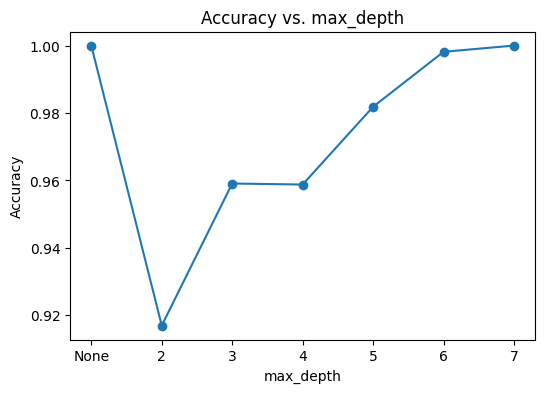

In [5]:

####################################
# Bước 7: Khảo sát ảnh hưởng của max_depth
####################################

# Chọn tỷ lệ mặc định để dùng cho khảo sát max_depth 
default_ratio = 0.6
X_train, X_test, y_train, y_test = splits_m[default_ratio]

max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

print("\n# Khảo sát ảnh hưởng của max_depth #")
for md in max_depth_values:
    print(f"\n# Huấn luyện và đánh giá với max_depth = {md}")
    dt_model_md = train_and_visualize_decision_tree(X_train, y_train, max_depth=md)
    acc_md = evaluate_model(dt_model_md, X_test, y_test)
    accuracies.append(acc_md)

# Vẽ biểu đồ thể hiện sự thay đổi accuracy theo max_depth
plt.figure(figsize=(6,4))
plt.plot([str(m) for m in max_depth_values], accuracies, marker='o')
plt.title("Accuracy vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.show()

